# 互评作业4：离群点分析与异常检测
**姓名**：聂宇翔  
**学号**：1120161722  
**所选择的数据文件**：wine_benchmarks和wave_benchmarks  
**Github地址**：https://github.com/JerrryNie/dataMining  
**注**：数据集处理代码、数据挖掘代码以及挖掘过程报告已经按照一定的顺序整理在这个notebook中  
**运行建议**：如果要对本人分析代码进行运行，只需要把该notebook与数据集放在同一个目录下（具体数据集的组织见代码目录部分）运行即可

# 内容  
## 1. 数据文件：wine_benchmarks
### 1.0. 数据预处理
### 1.1. 基于LOF模型的异常点检测
### 1.2. 基于XGBOD模型的异常点检测
### 1.3. 基于Feature Bagging的异常点检测
### 1.4. 基于Isolation Forest的异常点检测
### 1.5. 基于KNN的异常点检测
### 1.6. 算法之间的异常点检测结果比较
## 2. 数据文件：wave_benchmarks
### 1.0. 数据预处理
### 1.1. 基于LOF模型的异常点检测
### 1.2. 基于XGBOD模型的异常点检测
### 1.3. 基于Feature Bagging的异常点检测
### 1.4. 基于Isolation Forest的异常点检测
### 1.5. 基于KNN的异常点检测
### 1.6. 算法之间的异常点检测结果比较

首先导入本作业所需要的Python包：

In [1]:
import os
os.sys.executable

'F:\\anaconda\\python.exe'

In [2]:
from __future__ import division
from __future__ import print_function
from pyod.models.lof import LOF
from pyod.models.xgbod import XGBOD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y
from scipy.io import loadmat
import sklearn

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
# Random state.
RS = 20180101

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

from random import sample


C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1. 数据文件：wine_benchmarks

首先导入wine_benchmarks数据文件：

In [3]:
os.chdir(r'./dataset/wine/benchmarks/')
g = os.walk(r'./')
fileNames = []
for path,dir_list,file_list in g:
    for file_name in file_list:
        fileName = os.path.join(path, file_name)[2:]
        fileName = fileName.replace('\\', '/')
        fileNames.append(fileName)
os.chdir(r'../../../.')
first = fileNames[0]
fileNames.insert(0, first)

In [4]:
wineDfs = []

dirName = './dataset/wine/benchmarks/'
for file in fileNames:
    filePath = os.path.join(dirName, file)
    df = pd.read_csv(filePath, sep=',')
    wineDfs.append(df)

### 1.0. 数据预处理
首先我们取出其中的一个csv文件并查看：

In [5]:
df = wineDfs[0]
df.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,wine_point_3594,wine,regression,7,0.050492,nominal,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,wine_point_5089,wine,regression,5,0.082237,anomaly,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,wine_point_1912,wine,regression,6,0.290201,nominal,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,wine_point_4908,wine,regression,5,0.053559,anomaly,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,wine_point_2246,wine,regression,7,0.420300,nominal,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 17 columns):
point.id                3703 non-null object
motherset               3703 non-null object
origin                  3703 non-null object
original.label          3703 non-null int64
diff.score              3703 non-null float64
ground.truth            3703 non-null object
fixed.acidity           3703 non-null float64
volatile.acidity        3703 non-null float64
citric.acid             3703 non-null float64
residual.sugar          3703 non-null float64
chlorides               3703 non-null float64
free.sulfur.dioxide     3703 non-null float64
total.sulfur.dioxide    3703 non-null float64
density                 3703 non-null float64
pH                      3703 non-null float64
sulphates               3703 non-null float64
alcohol                 3703 non-null float64
dtypes: float64(12), int64(1), object(4)
memory usage: 491.9+ KB


查看一下是否需要进行缺失值的处理：

In [7]:
df.isna().sum()

point.id                0
motherset               0
origin                  0
original.label          0
diff.score              0
ground.truth            0
fixed.acidity           0
volatile.acidity        0
citric.acid             0
residual.sugar          0
chlorides               0
free.sulfur.dioxide     0
total.sulfur.dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

我们可以看到，其中ground.truth一列是每一个数据点为异常点或是正常点的标记。  
这个属性之后的所有属性都是该数据点的具体属性值。  
之前的属性是关于该数据点的一些描述信息，因此我们将这些信息列删去：

In [8]:
df = df.drop(columns=['point.id', 'motherset', 'origin', 'original.label', 'diff.score'])
df.head()

,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,nominal,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,anomaly,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,nominal,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,anomaly,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,nominal,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


然后把ground.truth中的值映射为0和1，便于之后的处理。其中“nominal”为0，“anomaly”为1：

In [9]:
df['ground.truth']=df['ground.truth'].map({'nominal':0, 'anomaly':1})
df.head()

,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,0,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,1,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,0,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,1,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,0,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


然后我们对wine_benchmarks中的所有文件的进行如上的处理：

In [10]:
for i, df in enumerate(wineDfs):
    df = df.drop(columns=['point.id', 'motherset', 'origin', 'original.label', 'diff.score'])
    df['ground.truth']=df['ground.truth'].map({'nominal':0, 'anomaly':1})
    wineDfs[i] = df

### 1.1. 基于LOF模型的异常点检测
循环遍历wine_benchmark中的每一个数据文件，  
按6:4的比例划分该文件为训练集和测试集，  
最后记录该次计算中的ROC值以及整个模型的平均ROC：

In [11]:
lofROC = []
for i, df in enumerate(wineDfs):
    # 到时候要把每一个filename都print出来
    print(fileNames[i])
    X  = df.iloc[:, 1:].values
    y = df.iloc[:, :1].values
    y = y.ravel()
    X, y = check_X_y(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=42)
    clf_name = 'LOF'
    clf = LOF(n_jobs=-1)
    clf.fit(X_train)
    
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)
    
    try:
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)
        lofROC.append(sklearn.metrics.roc_auc_score(y_test, y_test_scores))
        print()
    except Exception:
        continue
        
    if i == 0:
        X_lof = X_test
        y_lof = y_test_pred
        
lofAver = sum(lofROC)/len(lofROC)
print('Average ROC score on testing set:')
print(lofAver)

wine_benchmark_0001.csv

On Training Data:
LOF ROC:0.5614, precision @ rank n:0.4119

On Test Data:
LOF ROC:0.5243, precision @ rank n:0.3855

wine_benchmark_0284.csv

On Training Data:
LOF ROC:0.5204, precision @ rank n:0.5101

On Test Data:
LOF ROC:0.503, precision @ rank n:0.5079

wine_benchmark_1534.csv

On Training Data:
LOF ROC:0.5514, precision @ rank n:0.105

On Test Data:
LOF ROC:0.5615, precision @ rank n:0.1207

wine_benchmark_0462.csv

On Training Data:
LOF ROC:0.5234, precision @ rank n:0.0

On Test Data:
wine_benchmark_0425.csv

On Training Data:
LOF ROC:0.8171, precision @ rank n:0.0

On Test Data:
wine_benchmark_0368.csv

On Training Data:
LOF ROC:0.4661, precision @ rank n:0.0

On Test Data:
wine_benchmark_0642.csv

On Training Data:
LOF ROC:0.6162, precision @ rank n:0.0

On Test Data:
LOF ROC:0.6971, precision @ rank n:0.0

wine_benchmark_0401.csv

On Training Data:
LOF ROC:0.7296, precision @ rank n:0.0

On Test Data:
LOF ROC:0.7333, precision @ rank n:0.0

wine_ben

C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



On Training Data:
LOF ROC:0.4681, precision @ rank n:0.0

On Test Data:
LOF ROC:0.4387, precision @ rank n:0.0

wine_benchmark_0966.csv

On Training Data:
LOF ROC:0.5101, precision @ rank n:0.0

On Test Data:
LOF ROC:0.5548, precision @ rank n:0.0625

wine_benchmark_0456.csv

On Training Data:
LOF ROC:0.5319, precision @ rank n:0.0

On Test Data:
LOF ROC:0.1136, precision @ rank n:0.0

wine_benchmark_1280.csv

On Training Data:
LOF ROC:0.5109, precision @ rank n:0.065

On Test Data:
LOF ROC:0.5307, precision @ rank n:0.0417

wine_benchmark_0980.csv

On Training Data:
LOF ROC:0.5473, precision @ rank n:0.0

On Test Data:
LOF ROC:0.6012, precision @ rank n:0.0

wine_benchmark_1069.csv

On Training Data:
LOF ROC:0.4708, precision @ rank n:0.0

On Test Data:
LOF ROC:0.558, precision @ rank n:0.0

wine_benchmark_1577.csv

On Training Data:
LOF ROC:0.5406, precision @ rank n:0.123

On Test Data:
LOF ROC:0.5287, precision @ rank n:0.1012

wine_benchmark_0039.csv

On Training Data:
LOF ROC:0.

### 1.2. 基于XGBOD模型的异常点检测
循环遍历wine_benchmark中的每一个数据文件，  
按6:4的比例划分该文件为训练集和测试集，  
最后记录该次计算中的ROC值以及整个模型的平均ROC：

In [12]:
xgbodROC = []
warnings.filterwarnings("ignore")
for i, df in enumerate(wineDfs):
    # 到时候要把每一个filename都print出来
    print(fileNames[i])
    X  = df.iloc[:, 1:].values
    y = df.iloc[:, :1].values
    y = y.ravel()
    X, y = check_X_y(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=42)
    clf_name = 'XGBOD'
    clf = XGBOD(random_state=42,n_jobs=-1,silent=False)
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)
    
    try:
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)
        xgbodROC.append(sklearn.metrics.roc_auc_score(y_test, y_test_scores))
        print()
    except Exception:
        continue
    
    if i == 0:
        X_xgbod = X_test
        y_xgbod = y_test_pred
    
xgbodAver = sum(xgbodROC)/len(xgbodROC)
print('Average ROC score on testing set:')
print(xgbodAver)

wine_benchmark_0001.csv
[21:08:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



On Training Data:
XGBOD ROC:0.9217, precision @ rank n:0.7874

On Test Data:
XGBOD ROC:0.829, precision @ rank n:0.6614

wine_benchmark_0284.csv
[21:08:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



On Training Data:
XGBOD ROC:0.9969, precision @ rank n:0.9699

[21:14:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



On Training Data:
XGBOD ROC:0.9743, precision @ rank n:0.75

On Test Data:
XGBOD ROC:0.7892, precision @ rank n:0.3158

wine_benchmark_0758.csv
[21:15:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



On Training Data:
XGBOD ROC:1.0, precision @ rank n:1.0

On Test Data:
XGBOD ROC:0.533


On Training Data:
XGBOD ROC:0.9368, precision @ rank n:0.8175

On Test Data:
XGBOD ROC:0.8335, precision @ rank n:0.6747

wine_benchmark_0941.csv
[21:21:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



On Training Data:
XGBOD ROC:1.0, precision @ rank n:1.0

On Test Data:
XGBOD ROC:0.7619, precision @ rank n:0.0714

wine_benchmark_0017.csv
[21:21:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verifi


On Training Data:
XGBOD ROC:1.0, precision @ rank n:1.0

On Test Data:
XGBOD ROC:0.7812, precision @ rank n:0.0

wine_benchmark_1646.csv
[21:27:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



On Training Data:
XGBOD ROC:0.969, precision @ rank n:0.7411

On Test Data:
XGBOD ROC:0.7789, precision @ rank n:0.3273

wine_benchmark_1628.csv
[21:27:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

### 1.3. 基于Feature Bagging的异常点检测
循环遍历wine_benchmark中的每一个数据文件，  
按6:4的比例划分该文件为训练集和测试集，  
最后记录该次计算中的ROC值以及整个模型的平均ROC：

In [13]:
fbROC = []
for i, df in enumerate(wineDfs):
    # 到时候要把每一个filename都print出来
    print(fileNames[i])
    X  = df.iloc[:, 1:].values
    y = df.iloc[:, :1].values
    y = y.ravel()
    X, y = check_X_y(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=42)
    clf_name = 'Feature Bagging'
    clf = FeatureBagging(check_estimator=False, n_jobs=-1)
    clf.fit(X_train)
    
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)
    
    try:
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)
        fbROC.append(sklearn.metrics.roc_auc_score(y_test, y_test_scores))
        print()
    except Exception:
        continue
        
    if i == 0:
        X_fb = X_test
        y_fb= y_test_pred
    
fbAver = sum(fbROC)/len(fbROC)
print('Average ROC score on testing set:')
print(fbAver)

wine_benchmark_0001.csv

On Training Data:
Feature Bagging ROC:0.5698, precision @ rank n:0.4246

On Test Data:
Feature Bagging ROC:0.5371, precision @ rank n:0.3953

wine_benchmark_0284.csv

On Training Data:
Feature Bagging ROC:0.5289, precision @ rank n:0.5284

On Test Data:
Feature Bagging ROC:0.5093, precision @ rank n:0.5079

wine_benchmark_1534.csv

On Training Data:
Feature Bagging ROC:0.5462, precision @ rank n:0.1261

On Test Data:
Feature Bagging ROC:0.5643, precision @ rank n:0.1322

wine_benchmark_0462.csv

On Training Data:
Feature Bagging ROC:0.5141, precision @ rank n:0.0

On Test Data:
wine_benchmark_0425.csv

On Training Data:
Feature Bagging ROC:0.7928, precision @ rank n:0.0

On Test Data:
wine_benchmark_0368.csv

On Training Data:
Feature Bagging ROC:0.4406, precision @ rank n:0.0

On Test Data:
wine_benchmark_0642.csv

On Training Data:
Feature Bagging ROC:0.627, precision @ rank n:0.0

On Test Data:
Feature Bagging ROC:0.6891, precision @ rank n:0.0

wine_benchma


On Training Data:
Feature Bagging ROC:0.5797, precision @ rank n:0.0

On Test Data:
Feature Bagging ROC:0.5426, precision @ rank n:0.0

wine_benchmark_1025.csv

On Training Data:
Feature Bagging ROC:0.6165, precision @ rank n:0.0

On Test Data:
Feature Bagging ROC:0.5271, precision @ rank n:0.0667

wine_benchmark_0942.csv

On Training Data:
Feature Bagging ROC:0.6224, precision @ rank n:0.0

On Test Data:
Feature Bagging ROC:0.6053, precision @ rank n:0.0

wine_benchmark_0607.csv

On Training Data:
Feature Bagging ROC:0.5807, precision @ rank n:0.0

On Test Data:
Feature Bagging ROC:0.4867, precision @ rank n:0.0

wine_benchmark_1263.csv

On Training Data:
Feature Bagging ROC:0.627, precision @ rank n:0.072

On Test Data:
Feature Bagging ROC:0.6207, precision @ rank n:0.1286

wine_benchmark_1551.csv

On Training Data:
Feature Bagging ROC:0.5674, precision @ rank n:0.1387

On Test Data:
Feature Bagging ROC:0.5199, precision @ rank n:0.1207

wine_benchmark_1528.csv

On Training Data:
Fe

### 1.4. 基于Isolation Forest的异常点检测
循环遍历wine_benchmark中的每一个数据文件，  
按6:4的比例划分该文件为训练集和测试集，  
最后记录该次计算中的ROC值以及整个模型的平均ROC：

In [14]:
iforestROC = []
for i, df in enumerate(wineDfs):
    # 到时候要把每一个filename都print出来
    print(fileNames[i])
    X  = df.iloc[:, 1:].values
    y = df.iloc[:, :1].values
    y = y.ravel()
    X, y = check_X_y(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=42)
    clf_name = 'IForest'
    clf = IForest(n_jobs=-1)
    clf.fit(X_train)
    
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)
    
    try:
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)
        iforestROC.append(sklearn.metrics.roc_auc_score(y_test, y_test_scores))
        print()
    except Exception:
        continue
    
    if i == 0:
        X_iforest = X_test
        y_iforest = y_test_pred
    
iforestAver = sum(iforestROC)/len(iforestROC)
print('Average ROC score on testing set:')
print(iforestAver)

wine_benchmark_0001.csv

On Training Data:
IForest ROC:0.5707, precision @ rank n:0.4374

On Test Data:
IForest ROC:0.5465, precision @ rank n:0.3992

wine_benchmark_0284.csv

On Training Data:
IForest ROC:0.4869, precision @ rank n:0.4849

On Test Data:
IForest ROC:0.4943, precision @ rank n:0.4921

wine_benchmark_1534.csv

On Training Data:
IForest ROC:0.5623, precision @ rank n:0.1429

On Test Data:
IForest ROC:0.582, precision @ rank n:0.1667

wine_benchmark_0462.csv

On Training Data:
IForest ROC:0.5064, precision @ rank n:0.0

On Test Data:
wine_benchmark_0425.csv

On Training Data:
IForest ROC:0.718, precision @ rank n:0.0

On Test Data:
wine_benchmark_0368.csv

On Training Data:
IForest ROC:0.6033, precision @ rank n:0.0

On Test Data:
wine_benchmark_0642.csv

On Training Data:
IForest ROC:0.6104, precision @ rank n:0.0

On Test Data:
IForest ROC:0.6783, precision @ rank n:0.0

wine_benchmark_0401.csv

On Training Data:
IForest ROC:0.8252, precision @ rank n:0.0

On Test Data:



On Training Data:
IForest ROC:0.6143, precision @ rank n:0.1841

On Test Data:
IForest ROC:0.5919, precision @ rank n:0.1272

wine_benchmark_1611.csv

On Training Data:
IForest ROC:0.5598, precision @ rank n:0.1059

On Test Data:
IForest ROC:0.5754, precision @ rank n:0.142

wine_benchmark_1590.csv

On Training Data:
IForest ROC:0.5994, precision @ rank n:0.17

On Test Data:
IForest ROC:0.6083, precision @ rank n:0.1758

wine_benchmark_1067.csv

On Training Data:
IForest ROC:0.5297, precision @ rank n:0.0

On Test Data:
IForest ROC:0.457, precision @ rank n:0.0

Average ROC score on testing set:
0.5871827315890591


### 1.5. 基于KNN的异常点检测
循环遍历wine_benchmark中的每一个数据文件，  
按6:4的比例划分该文件为训练集和测试集，  
最后记录该次计算中的ROC值以及整个模型的平均ROC：

In [15]:
knnROC = []
for i, df in enumerate(wineDfs):
    # 到时候要把每一个filename都print出来
    print(fileNames[i])
    X  = df.iloc[:, 1:].values
    y = df.iloc[:, :1].values
    y = y.ravel()
    X, y = check_X_y(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=42)
    clf_name = 'KNN'
    clf = KNN(n_jobs=-1)
    clf.fit(X_train)
    
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)
    
    try:
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)
        knnROC.append(sklearn.metrics.roc_auc_score(y_test, y_test_scores))
        print()
    except Exception:
        continue
    
    if i == 0:
        X_knn = X_test
        y_knn = y_test_pred
    
knnAver = sum(knnROC)/len(knnROC)
print('Average ROC score on testing set:')
print(knnAver)

wine_benchmark_0001.csv

On Training Data:
KNN ROC:0.5671, precision @ rank n:0.4228

On Test Data:
KNN ROC:0.5245, precision @ rank n:0.3679

wine_benchmark_0284.csv

On Training Data:
KNN ROC:0.5179, precision @ rank n:0.5117

On Test Data:
KNN ROC:0.5524, precision @ rank n:0.5238

wine_benchmark_1534.csv

On Training Data:
KNN ROC:0.5749, precision @ rank n:0.1176

On Test Data:
KNN ROC:0.5933, precision @ rank n:0.1437

wine_benchmark_0462.csv

On Training Data:
KNN ROC:0.5328, precision @ rank n:0.0

On Test Data:
wine_benchmark_0425.csv

On Training Data:
KNN ROC:0.8051, precision @ rank n:0.0

On Test Data:
wine_benchmark_0368.csv

On Training Data:
KNN ROC:0.4972, precision @ rank n:0.0

On Test Data:
wine_benchmark_0642.csv

On Training Data:
KNN ROC:0.7056, precision @ rank n:0.0

On Test Data:
KNN ROC:0.7007, precision @ rank n:0.0

wine_benchmark_0401.csv

On Training Data:
KNN ROC:0.7968, precision @ rank n:0.0

On Test Data:
KNN ROC:0.6874, precision @ rank n:0.0

wine_b


On Training Data:
KNN ROC:0.5525, precision @ rank n:0.0455

On Test Data:
KNN ROC:0.4423, precision @ rank n:0.0

Average ROC score on testing set:
0.5871744672330024


### 1.6. 算法之间的异常点检测结果比较
在本节我们首先通过各种算法下ROC的平均值，对各个算法的最终结果进行比较分析；  
然后利用t-SNE的方法，对第一组数据点进行降维，然后通过可视化的方式得到最终的结果。  
我们首先对图形绘制函数进行定义：

In [16]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=20,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(2):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=34)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

首先对LOF算法下的异常点检测结果进行可视化：

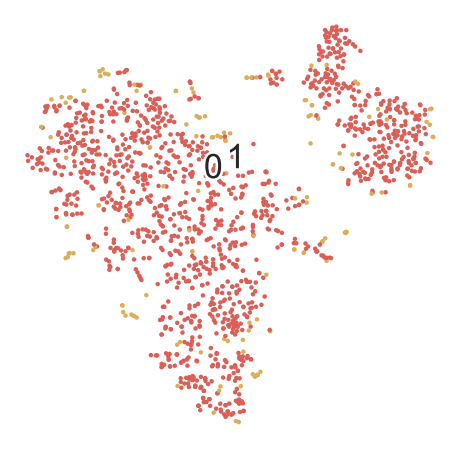

In [17]:
X = X_lof
y = y_lof
digits_proj = TSNE(random_state=RS, n_jobs=-1).fit_transform(X)

scatter(digits_proj, y)
foo_fig = plt.gcf() # 'get current figure'
plt.show()

In [18]:
print('LOF ROC:')
print(lofAver)

LOF ROC:
0.5736031162501333


其次对XGBOD算法下的异常点检测结果进行可视化：

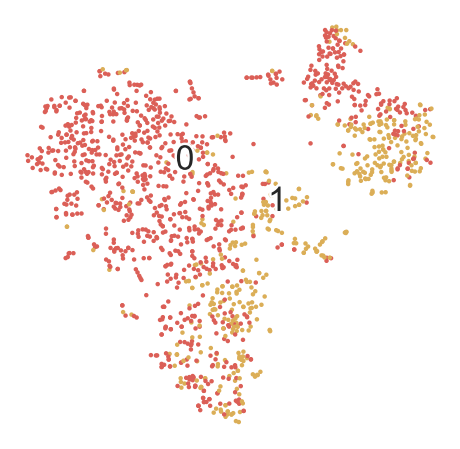

In [19]:
X = X_xgbod
y = y_xgbod
digits_proj = TSNE(random_state=RS, n_jobs=-1).fit_transform(X)

scatter(digits_proj, y)
foo_fig = plt.gcf() # 'get current figure'
plt.show()

In [20]:
print('XGBOD ROC:')
print(xgbodAver)

XGBOD ROC:
0.7202581292107726


然后对Feature Bagging算法下的异常点检测结果进行可视化：

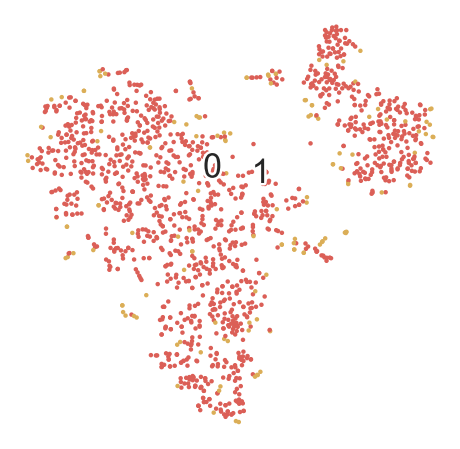

In [21]:
X = X_fb
y = y_fb
digits_proj = TSNE(random_state=RS, n_jobs=-1).fit_transform(X)

scatter(digits_proj, y)
foo_fig = plt.gcf() # 'get current figure'
plt.show()

In [22]:
print('Feature Bagging ROC:')
print(fbAver)

Feature Bagging ROC:
0.5769612063774472


然后对Isolation Forest算法下的异常点检测结果进行可视化：

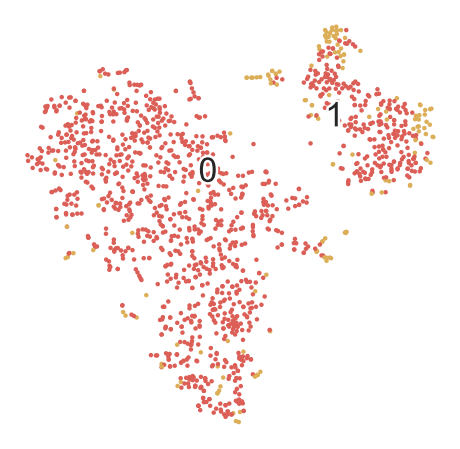

In [23]:
X = X_iforest
y = y_iforest
digits_proj = TSNE(random_state=RS, n_jobs=-1).fit_transform(X)

scatter(digits_proj, y)
foo_fig = plt.gcf() # 'get current figure'
plt.show()

In [24]:
print('Isolation Forest ROC:')
print(lofAver)

Isolation Forest ROC:
0.5736031162501333


最后对KNN算法下的异常点检测结果进行可视化：

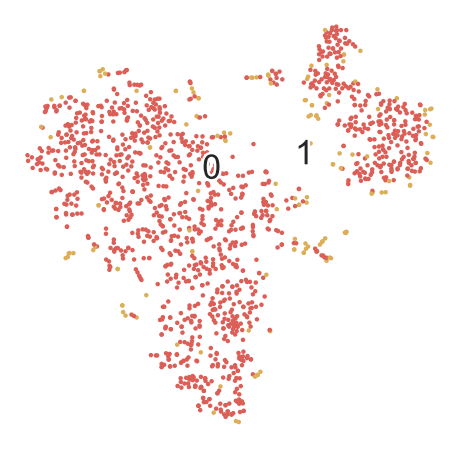

In [25]:
X = X_knn
y = y_knn
digits_proj = TSNE(random_state=RS, n_jobs=-1).fit_transform(X)

scatter(digits_proj, y)
foo_fig = plt.gcf() # 'get current figure'
plt.show()

In [26]:
print('KNN ROC:')
print(knnAver)

KNN ROC:
0.5871744672330024


从上述可视化和ROC值的计算结果我们可以得知的是，  
首先监督的方法XGBOD在ROC指标上比其他4种无监督的方法效果要好；  
其次，在无监督方法之间的比较中，我们可以看出：  
Isolation Forest方法和KNN方法可以较好地将不同的数据点划分开来，  
而LOF和Feature Bagging方法则难以将异常点和正常点区别开。  
在下面的部分中，我们将从wave_benchmarks出发，探究不同数据集上的结果是否能支持上述结论（或者是反对上述结论）。

## 2. 数据文件：wave_benchmarks

首先清理掉wine_benchmarks中的数据并导入wave_benchmarks数据文件：

In [27]:
wineDfs = []

os.chdir(r'./dataset/wave/benchmarks/')
g = os.walk(r'./')
fileNames = []
for path,dir_list,file_list in g:
    for file_name in file_list:
        fileName = os.path.join(path, file_name)[2:]
        fileName = fileName.replace('\\', '/')
        fileNames.append(fileName)
os.chdir(r'../../../.')
first = fileNames[0]
fileNames.insert(0, first)

In [28]:
waveDfs = []

dirName = './dataset/wave/benchmarks/'
for file in fileNames:
    filePath = os.path.join(dirName, file)
    df = pd.read_csv(filePath, sep=',')
    waveDfs.append(df)

### 2.0. 数据预处理
首先我们取出其中的一个csv文件并查看：

In [29]:
df = waveDfs[0]
df.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,V.3,...,V.11,V.12,V.13,V.14,V.15,V.16,V.17,V.18,V.19,V.20
0,wave_point_0242,wave,multiclass,2,0.001130,nominal,0.440395,-0.293023,-1.374141,-2.382361,...,0.235635,0.581920,0.745048,0.674833,0.397361,0.008963,1.677061,0.800549,-0.441398,-1.583270
1,wave_point_4490,wave,multiclass,0,0.474350,anomaly,0.093905,-0.093717,1.891936,1.002227,...,-0.134625,-1.791554,-0.698042,-0.598220,-0.894968,-0.823398,0.799381,-0.744561,0.418648,-1.613359
2,wave_point_0454,wave,multiclass,2,0.000153,nominal,1.123475,-0.558765,0.688201,-1.336601,...,1.538160,1.629397,1.017757,-0.241567,-0.094166,0.272444,-1.012604,-1.337549,-0.885293,-0.219266
3,wave_point_2033,wave,multiclass,0,0.354121,anomaly,1.301670,-1.479368,-1.087939,-1.025700,...,-0.167684,1.193453,1.012076,2.022189,3.236067,2.170706,0.990489,2.095101,2.767593,1.435593
4,wave_point_2294,wave,multiclass,0,0.349918,anomaly,-0.896067,-0.055754,-0.380850,1.221271,...,-1.536327,-1.500924,-0.976433,-0.261381,-0.342690,-1.571924,-0.403890,-0.569170,-1.181223,-0.640502


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3010 entries, 0 to 3009
Data columns (total 27 columns):
point.id          3010 non-null object
motherset         3010 non-null object
origin            3010 non-null object
original.label    3010 non-null int64
diff.score        3010 non-null float64
ground.truth      3010 non-null object
V                 3010 non-null float64
V.1               3010 non-null float64
V.2               3010 non-null float64
V.3               3010 non-null float64
V.4               3010 non-null float64
V.5               3010 non-null float64
V.6               3010 non-null float64
V.7               3010 non-null float64
V.8               3010 non-null float64
V.9               3010 non-null float64
V.10              3010 non-null float64
V.11              3010 non-null float64
V.12              3010 non-null float64
V.13              3010 non-null float64
V.14              3010 non-null float64
V.15              3010 non-null float64
V.16              3

查看一下是否需要进行缺失值的处理：

In [31]:
df.isna().sum()

point.id          0
motherset         0
origin            0
original.label    0
diff.score        0
ground.truth      0
V                 0
V.1               0
V.2               0
V.3               0
V.4               0
V.5               0
V.6               0
V.7               0
V.8               0
V.9               0
V.10              0
V.11              0
V.12              0
V.13              0
V.14              0
V.15              0
V.16              0
V.17              0
V.18              0
V.19              0
V.20              0
dtype: int64

我们可以看到，其中ground.truth一列是每一个数据点为异常点或是正常点的标记。  
这个属性之后的所有属性都是该数据点的具体属性值。  
之前的属性是关于该数据点的一些描述信息，因此我们将这些信息列删去：

In [32]:
df = df.drop(columns=['point.id', 'motherset', 'origin', 'original.label', 'diff.score'])
df.head()

,ground.truth,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8,...,V.11,V.12,V.13,V.14,V.15,V.16,V.17,V.18,V.19,V.20
0,nominal,0.440395,-0.293023,-1.374141,-2.382361,-0.566581,-0.163878,-0.675575,-0.406186,-0.121499,...,0.235635,0.581920,0.745048,0.674833,0.397361,0.008963,1.677061,0.800549,-0.441398,-1.583270
1,anomaly,0.093905,-0.093717,1.891936,1.002227,1.346078,0.547184,0.981357,0.916787,0.473712,...,-0.134625,-1.791554,-0.698042,-0.598220,-0.894968,-0.823398,0.799381,-0.744561,0.418648,-1.613359
2,nominal,1.123475,-0.558765,0.688201,-1.336601,-0.685750,-0.626896,-0.789675,0.441433,0.557883,...,1.538160,1.629397,1.017757,-0.241567,-0.094166,0.272444,-1.012604,-1.337549,-0.885293,-0.219266
3,anomaly,1.301670,-1.479368,-1.087939,-1.025700,0.112681,-1.591515,-1.335371,-1.683342,-1.660629,...,-0.167684,1.193453,1.012076,2.022189,3.236067,2.170706,0.990489,2.095101,2.767593,1.435593
4,anomaly,-0.896067,-0.055754,-0.380850,1.221271,1.965756,0.822789,1.283970,1.999220,-0.361988,...,-1.536327,-1.500924,-0.976433,-0.261381,-0.342690,-1.571924,-0.403890,-0.569170,-1.181223,-0.640502


然后把ground.truth中的值映射为0和1，便于之后的处理。其中“nominal”为0，“anomaly”为1：

In [33]:
df['ground.truth']=df['ground.truth'].map({'nominal':0, 'anomaly':1})
df.head()

,ground.truth,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8,...,V.11,V.12,V.13,V.14,V.15,V.16,V.17,V.18,V.19,V.20
0,0,0.440395,-0.293023,-1.374141,-2.382361,-0.566581,-0.163878,-0.675575,-0.406186,-0.121499,...,0.235635,0.581920,0.745048,0.674833,0.397361,0.008963,1.677061,0.800549,-0.441398,-1.583270
1,1,0.093905,-0.093717,1.891936,1.002227,1.346078,0.547184,0.981357,0.916787,0.473712,...,-0.134625,-1.791554,-0.698042,-0.598220,-0.894968,-0.823398,0.799381,-0.744561,0.418648,-1.613359
2,0,1.123475,-0.558765,0.688201,-1.336601,-0.685750,-0.626896,-0.789675,0.441433,0.557883,...,1.538160,1.629397,1.017757,-0.241567,-0.094166,0.272444,-1.012604,-1.337549,-0.885293,-0.219266
3,1,1.301670,-1.479368,-1.087939,-1.025700,0.112681,-1.591515,-1.335371,-1.683342,-1.660629,...,-0.167684,1.193453,1.012076,2.022189,3.236067,2.170706,0.990489,2.095101,2.767593,1.435593
4,1,-0.896067,-0.055754,-0.380850,1.221271,1.965756,0.822789,1.283970,1.999220,-0.361988,...,-1.536327,-1.500924,-0.976433,-0.261381,-0.342690,-1.571924,-0.403890,-0.569170,-1.181223,-0.640502


然后我们对wave_benchmarks中的所有文件的进行如上的处理：

In [34]:
for i, df in enumerate(waveDfs):
    df = df.drop(columns=['point.id', 'motherset', 'origin', 'original.label', 'diff.score'])
    df['ground.truth']=df['ground.truth'].map({'nominal':0, 'anomaly':1})
    waveDfs[i] = df

### 2.1. 基于LOF模型的异常点检测
循环遍历wave_benchmark中的每一个数据文件，  
按6:4的比例划分该文件为训练集和测试集，  
最后记录该次计算中的ROC值以及整个模型的平均ROC：

In [35]:
lofROC = []
for i, df in enumerate(waveDfs):
    # 到时候要把每一个filename都print出来
    print(fileNames[i])
    X  = df.iloc[:, 1:].values
    y = df.iloc[:, :1].values
    y = y.ravel()
    X, y = check_X_y(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=42)
    clf_name = 'LOF'
    clf = LOF(n_jobs=-1)
    clf.fit(X_train)
    
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)
    
    try:
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)
        lofROC.append(sklearn.metrics.roc_auc_score(y_test, y_test_scores))
        print()
    except Exception:
        continue
    
    if i == 0:
        X_lof = X_test
        y_lof = y_test_pred
        
lofAver = sum(lofROC)/len(lofROC)
print('Average ROC score on testing set:')
print(lofAver)

wave_benchmark_0001.csv

On Training Data:
LOF ROC:0.5351, precision @ rank n:0.3357

On Test Data:
LOF ROC:0.525, precision @ rank n:0.3477

wave_benchmark_1577.csv

On Training Data:
LOF ROC:0.5651, precision @ rank n:0.1238

On Test Data:
LOF ROC:0.537, precision @ rank n:0.1203

wave_benchmark_0014.csv

On Training Data:
LOF ROC:0.5342, precision @ rank n:0.3405

On Test Data:
LOF ROC:0.4919, precision @ rank n:0.3026

wave_benchmark_0275.csv

On Training Data:
LOF ROC:0.5098, precision @ rank n:0.6475

On Test Data:
LOF ROC:0.4801, precision @ rank n:0.5362

wave_benchmark_0428.csv

On Training Data:
LOF ROC:0.7241, precision @ rank n:0.0

On Test Data:
wave_benchmark_1011.csv

On Training Data:
LOF ROC:0.6378, precision @ rank n:0.0476

On Test Data:
LOF ROC:0.659, precision @ rank n:0.0

wave_benchmark_0123.csv

On Training Data:
LOF ROC:0.5373, precision @ rank n:0.419

On Test Data:
LOF ROC:0.5312, precision @ rank n:0.3984

wave_benchmark_0195.csv

On Training Data:
LOF ROC:0

### 2.2. 基于XGBOD模型的异常点检测
循环遍历wave_benchmark中的每一个数据文件，  
按6:4的比例划分该文件为训练集和测试集，  
最后记录该次计算中的ROC值以及整个模型的平均ROC：

In [36]:
xgbodROC = []
warnings.filterwarnings("ignore")
for i, df in enumerate(waveDfs):
    # 到时候要把每一个filename都print出来
    print(fileNames[i])
    X  = df.iloc[:, 1:].values
    y = df.iloc[:, :1].values
    y = y.ravel()
    X, y = check_X_y(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=42)
    clf_name = 'XGBOD'
    clf = XGBOD(random_state=42,n_jobs=-1,silent=False)
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)
    
    try:
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)
        xgbodROC.append(sklearn.metrics.roc_auc_score(y_test, y_test_scores))
        print()
    except Exception:
        continue
    
    if i == 0:
        X_xgbod = X_test
        y_xgbod = y_test_pred
    
xgbodAver = sum(xgbodROC)/len(xgbodROC)
print('Average ROC score on testing set:')
print(xgbodAver)

wave_benchmark_0001.csv
[21:37:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



On Training Data:
XGBOD ROC:0.995, precision @ rank n:0.9426

On Test Data:
XGBOD ROC:0.9523, precision @ rank n:0.8153

wave_benchmark_1577.csv
[21:38:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



On Training Data:
XGBOD ROC:0.9997, precision @ rank n:0.9703


On Training Data:
XGBOD ROC:0.9985, precision @ rank n:0.9455

On Test Data:
XGBOD ROC:0.9451, precision @ rank n:0.6696

wave_benchmark_1279.csv
[21:42:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



On Training Data:
XGBOD ROC:1.0, precision @ rank n:1.0

On Test Data:
XGBOD ROC:0.9223, precision @ rank n:0.5

wave_benchmark_0409.csv
[21:43:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificat


On Training Data:
XGBOD ROC:0.9971, precision @ rank n:0.9637

On Test Data:
XGBOD ROC:0.9492, precision @ rank n:0.8051

wave_benchmark_0908.csv
[21:48:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



On Training Data:
XGBOD ROC:1.0, precision @ rank n:1.0

On Test Data:
XGBOD ROC:0.9671, precision @ rank n:0.4

wave_benchmark_0652.csv
[21:48:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificat


On Training Data:
XGBOD ROC:1.0, precision @ rank n:1.0

On Test Data:
wave_benchmark_1289.csv
[21:53:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



On Training Data:
XGBOD ROC:1.0, precision @ rank n:0.9785

On Test Data:
XGBOD ROC:0.9266, precision @ rank n:0.5758

wave_benchmark_0429.csv
[21:53:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

### 2.3. 基于Feature Bagging的异常点检测
循环遍历wave_benchmark中的每一个数据文件，  
按6:4的比例划分该文件为训练集和测试集，  
最后记录该次计算中的ROC值以及整个模型的平均ROC：

In [37]:
fbROC = []
for i, df in enumerate(waveDfs):
    # 到时候要把每一个filename都print出来
    print(fileNames[i])
    X  = df.iloc[:, 1:].values
    y = df.iloc[:, :1].values
    y = y.ravel()
    X, y = check_X_y(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=42)
    clf_name = 'Feature Bagging'
    clf = FeatureBagging(check_estimator=False, n_jobs=-1)
    clf.fit(X_train)
    
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)
    
    try:
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)
        fbROC.append(sklearn.metrics.roc_auc_score(y_test, y_test_scores))
        print()
    except Exception:
        continue
    
    if i == 0:
        X_fb = X_test
        y_fb= y_test_pred
    
fbAver = sum(fbROC)/len(fbROC)
print('Average ROC score on testing set:')
print(fbAver)

wave_benchmark_0001.csv

On Training Data:
Feature Bagging ROC:0.5417, precision @ rank n:0.3339

On Test Data:
Feature Bagging ROC:0.5238, precision @ rank n:0.3621

wave_benchmark_1577.csv

On Training Data:
Feature Bagging ROC:0.568, precision @ rank n:0.1188

On Test Data:
Feature Bagging ROC:0.5393, precision @ rank n:0.1203

wave_benchmark_0014.csv

On Training Data:
Feature Bagging ROC:0.5406, precision @ rank n:0.352

On Test Data:
Feature Bagging ROC:0.4962, precision @ rank n:0.3

wave_benchmark_0275.csv

On Training Data:
Feature Bagging ROC:0.5058, precision @ rank n:0.6311

On Test Data:
Feature Bagging ROC:0.4914, precision @ rank n:0.5217

wave_benchmark_0428.csv

On Training Data:
Feature Bagging ROC:0.7457, precision @ rank n:0.0

On Test Data:
wave_benchmark_1011.csv

On Training Data:
Feature Bagging ROC:0.659, precision @ rank n:0.0476

On Test Data:
Feature Bagging ROC:0.6794, precision @ rank n:0.0

wave_benchmark_0123.csv

On Training Data:
Feature Bagging ROC:0.


On Training Data:
Feature Bagging ROC:0.5596, precision @ rank n:0.3717

On Test Data:
Feature Bagging ROC:0.5341, precision @ rank n:0.3564

wave_benchmark_0730.csv

On Training Data:
Feature Bagging ROC:0.6225, precision @ rank n:0.0

On Test Data:
Feature Bagging ROC:0.154, precision @ rank n:0.0

wave_benchmark_0622.csv

On Training Data:
Feature Bagging ROC:0.6387, precision @ rank n:0.0

On Test Data:
Feature Bagging ROC:0.7605, precision @ rank n:0.1429

Average ROC score on testing set:
0.554272836858262


### 2.4. 基于Isolation Forest的异常点检测
循环遍历wave_benchmark中的每一个数据文件，  
按6:4的比例划分该文件为训练集和测试集，  
最后记录该次计算中的ROC值以及整个模型的平均ROC：

In [38]:
iforestROC = []
for i, df in enumerate(waveDfs):
    # 到时候要把每一个filename都print出来
    print(fileNames[i])
    X  = df.iloc[:, 1:].values
    y = df.iloc[:, :1].values
    y = y.ravel()
    X, y = check_X_y(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=42)
    clf_name = 'IForest'
    clf = IForest(n_jobs=-1)
    clf.fit(X_train)
    
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)
    
    try:
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)
        iforestROC.append(sklearn.metrics.roc_auc_score(y_test, y_test_scores))
        print()
    except Exception:
        continue
    
    if i == 0:
        X_iforest = X_test
        y_iforest = y_test_pred
    
iforestAver = sum(iforestROC)/len(iforestROC)
print('Average ROC score on testing set:')
print(iforestAver)

wave_benchmark_0001.csv

On Training Data:
IForest ROC:0.5155, precision @ rank n:0.3391

On Test Data:
IForest ROC:0.4928, precision @ rank n:0.3189

wave_benchmark_1577.csv

On Training Data:
IForest ROC:0.555, precision @ rank n:0.099

On Test Data:
IForest ROC:0.5307, precision @ rank n:0.0827

wave_benchmark_0014.csv

On Training Data:
IForest ROC:0.5043, precision @ rank n:0.3405

On Test Data:
IForest ROC:0.501, precision @ rank n:0.3231

wave_benchmark_0275.csv

On Training Data:
IForest ROC:0.5474, precision @ rank n:0.6311

On Test Data:
IForest ROC:0.551, precision @ rank n:0.5942

wave_benchmark_0428.csv

On Training Data:
IForest ROC:0.932, precision @ rank n:0.0

On Test Data:
wave_benchmark_1011.csv

On Training Data:
IForest ROC:0.63, precision @ rank n:0.0

On Test Data:
IForest ROC:0.6823, precision @ rank n:0.0

wave_benchmark_0123.csv

On Training Data:
IForest ROC:0.4473, precision @ rank n:0.3356

On Test Data:
IForest ROC:0.4517, precision @ rank n:0.3351

wave_b

### 2.5. 基于KNN的异常点检测
循环遍历wave_benchmark中的每一个数据文件，  
按6:4的比例划分该文件为训练集和测试集，  
最后记录该次计算中的ROC值以及整个模型的平均ROC：

In [39]:
knnROC = []
for i, df in enumerate(waveDfs):
    # 到时候要把每一个filename都print出来
    print(fileNames[i])
    X  = df.iloc[:, 1:].values
    y = df.iloc[:, :1].values
    y = y.ravel()
    X, y = check_X_y(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=42)
    clf_name = 'KNN'
    clf = KNN(n_jobs=-1)
    clf.fit(X_train)
    
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)
    
    try:
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)
        knnROC.append(sklearn.metrics.roc_auc_score(y_test, y_test_scores))
        print()
    except Exception:
        continue
    
    if i == 0:
        X_knn = X_test
        y_knn = y_test_pred
    
knnAver = sum(knnROC)/len(knnROC)
print('Average ROC score on testing set:')
print(knnAver)

wave_benchmark_0001.csv

On Training Data:
KNN ROC:0.5623, precision @ rank n:0.3652

On Test Data:
KNN ROC:0.5438, precision @ rank n:0.3765

wave_benchmark_1577.csv

On Training Data:
KNN ROC:0.5875, precision @ rank n:0.1634

On Test Data:
KNN ROC:0.5548, precision @ rank n:0.1203

wave_benchmark_0014.csv

On Training Data:
KNN ROC:0.5514, precision @ rank n:0.3668

On Test Data:
KNN ROC:0.4946, precision @ rank n:0.3051

wave_benchmark_0275.csv

On Training Data:
KNN ROC:0.5177, precision @ rank n:0.6475

On Test Data:
KNN ROC:0.4504, precision @ rank n:0.5217

wave_benchmark_0428.csv

On Training Data:
KNN ROC:0.5696, precision @ rank n:0.0

On Test Data:
wave_benchmark_1011.csv

On Training Data:
KNN ROC:0.6674, precision @ rank n:0.0476

On Test Data:
KNN ROC:0.6373, precision @ rank n:0.0

wave_benchmark_0123.csv

On Training Data:
KNN ROC:0.4839, precision @ rank n:0.374

On Test Data:
KNN ROC:0.4816, precision @ rank n:0.372

wave_benchmark_0195.csv

On Training Data:
KNN ROC

### 2.6. 算法之间的异常点检测结果比较
在本节我们首先通过各种算法下ROC的平均值，对各个算法的最终结果进行比较分析；  
然后利用t-SNE的方法，对第一组数据点进行降维，然后通过可视化的方式得到最终的结果。  
我们首先对图形绘制函数进行定义：

In [40]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=20,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(2):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=34)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

首先对LOF算法下的异常点检测结果进行可视化：

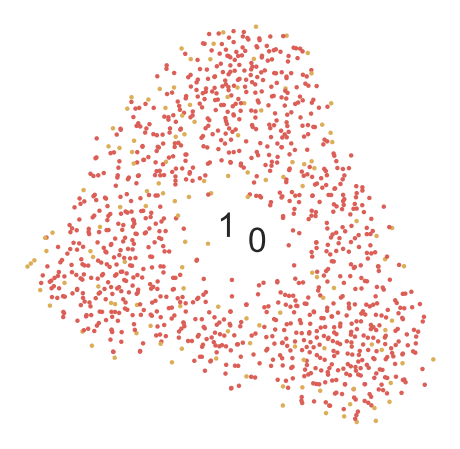

In [41]:
X = X_lof
y = y_lof
digits_proj = TSNE(random_state=RS, n_jobs=-1).fit_transform(X)

scatter(digits_proj, y)
foo_fig = plt.gcf() # 'get current figure'
plt.show()

In [42]:
print('LOF ROC:')
print(lofAver)

LOF ROC:
0.5504739454681201


其次对XGBOD算法下的异常点检测结果进行可视化：

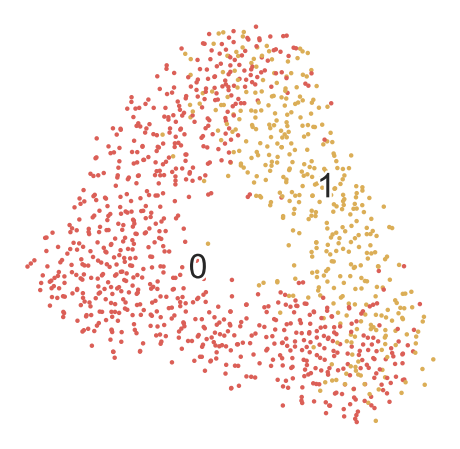

In [43]:
X = X_xgbod
y = y_xgbod
digits_proj = TSNE(random_state=RS, n_jobs=-1).fit_transform(X)

scatter(digits_proj, y)
foo_fig = plt.gcf() # 'get current figure'
plt.show()

In [44]:
print('XGBOD ROC:')
print(xgbodAver)

XGBOD ROC:
0.8328368337633795


然后对Feature Bagging算法下的异常点检测结果进行可视化：

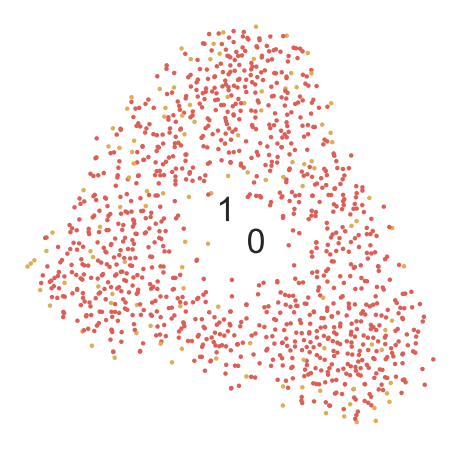

In [45]:
X = X_fb
y = y_fb
digits_proj = TSNE(random_state=RS, n_jobs=-1).fit_transform(X)

scatter(digits_proj, y)
foo_fig = plt.gcf() # 'get current figure'
plt.show()

In [46]:
print('Feature Bagging ROC:')
print(fbAver)

Feature Bagging ROC:
0.554272836858262


然后对Isolation Forest算法下的异常点检测结果进行可视化：

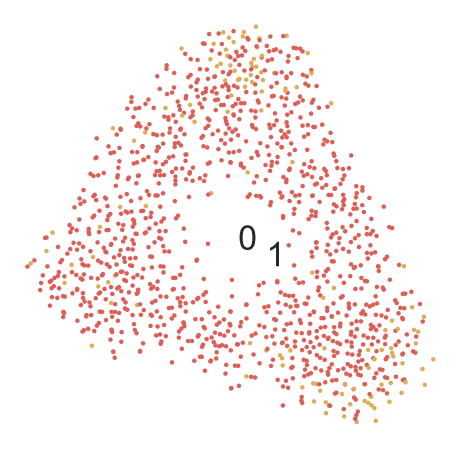

In [47]:
X = X_iforest
y = y_iforest
digits_proj = TSNE(random_state=RS, n_jobs=-1).fit_transform(X)

scatter(digits_proj, y)
foo_fig = plt.gcf() # 'get current figure'
plt.show()

In [48]:
print('Isolation Forest ROC:')
print(lofAver)

Isolation Forest ROC:
0.5504739454681201


最后对KNN算法下的异常点检测结果进行可视化：

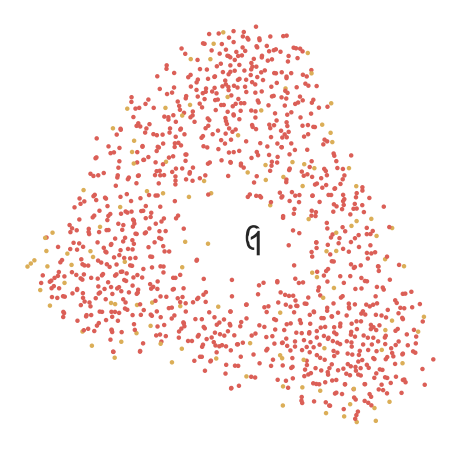

In [49]:
X = X_knn
y = y_knn
digits_proj = TSNE(random_state=RS, n_jobs=-1).fit_transform(X)

scatter(digits_proj, y)
foo_fig = plt.gcf() # 'get current figure'
plt.show()

In [50]:
print('KNN ROC:')
print(knnAver)

KNN ROC:
0.5494995001106352


从上述可视化和ROC值的计算结果我们可以得知的是，  
同样监督的方法XGBOD在ROC指标上比其他4种无监督的方法效果要好；  
其次，在无监督方法之间的比较中，我们可以得到与在wine_benchmarks数据集中略微不同的结果，即  
监督方法XGBOD比无监督方法效果要好。
在无监督方法之间的比较中，我们可以看出：  
Isolation Forest方法可以较好地将不同的数据点划分开来，  
而LOF，Feature Bagging和KNN方法则难以将异常点和正常点区别开。

因此我们得到的最终结论是，在一个数据集上运行效果良好的算法，不一定能在另一个数据集上取得同样好的效果。